In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_dark_channel(img, wind_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    img = cv2.copyMakeBorder(img,wind_size//2,wind_size//2,wind_size//2,wind_size//2,cv2.BORDER_CONSTANT,value=[255,255,255])    
    no_rows = img.shape[0]
    no_cols = img.shape[1]
    min_channel = np.zeros((no_rows, no_cols), dtype=np.uint8)
    for row in range(no_rows):
        for col in range(no_cols):
            min_channel[row-wind_size//2][col-wind_size//2] = np.min(img[row,col,:])
    for row in range(wind_size//2, no_rows-wind_size//2):
        for col in range(wind_size//2, no_cols-wind_size//2):
            dark_channel[row-wind_size//2][col-wind_size//2] = np.min(min_channel[row-wind_size//2:row+wind_size//2,col-wind_size//2:col+wind_size//2])
    return dark_channel

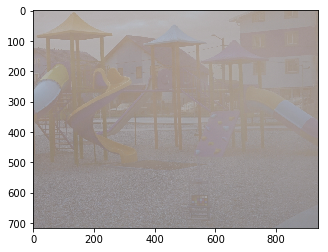

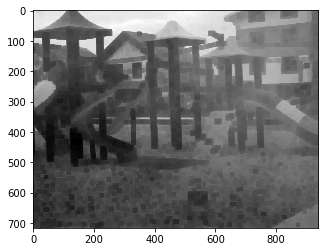

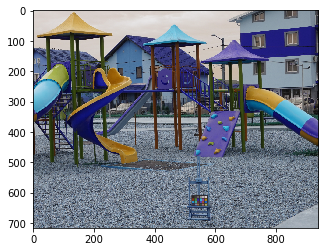

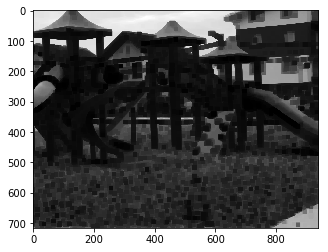

In [13]:
img = cv2.imread("Dataset/O-Haze/hazy/26_outdoor_hazy.jpg")
img = cv2.resize(img,(0,0),fx=0.25,fy=0.25)
plt.imshow(img)
plt.show()
dark_channel_img = get_dark_channel(img, 15)
plt.imshow(dark_channel_img,'gray')
plt.show()
img = cv2.imread("Dataset/O-Haze/GT/26_outdoor_GT.jpg")
img = cv2.resize(img,(0,0),fx=0.25,fy=0.25)
plt.imshow(img)
plt.show()
dark_channel_img = get_dark_channel(img, 15)
plt.imshow(dark_channel_img,'gray')
plt.show()